In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_json="eval_results/meta-llama_Meta-Llama-3.1-8B-Instruct.json"
target_json="eval_results/meta-llama_Meta-Llama-3.1-70B-Instruct.json"

In [38]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]


        #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
        #unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
        #pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
        # 正規表現によるマッチング
        #match = re.search(pattern, text)

        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            pred_list.append(float(predict))
        else:
            pred_list.append(None)

    return pred_list

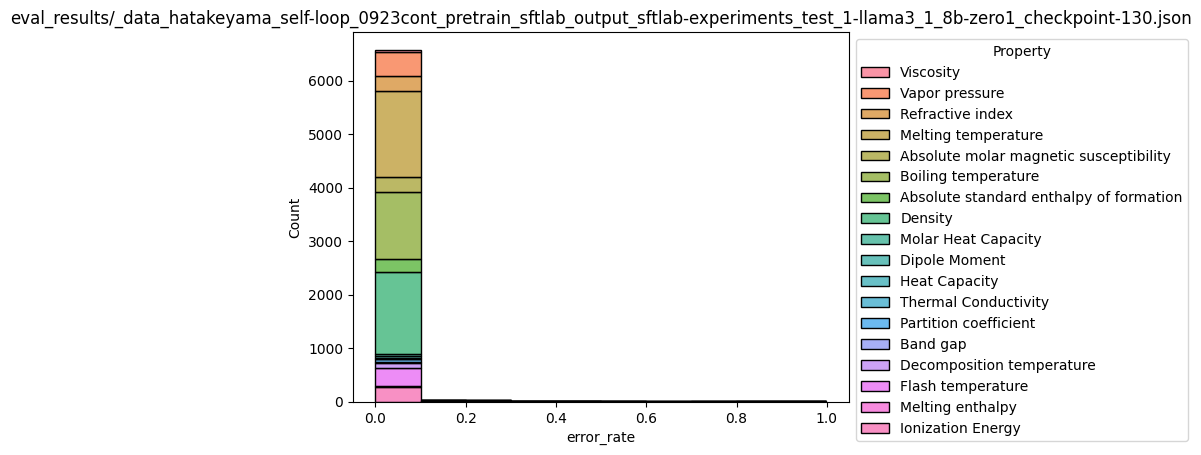

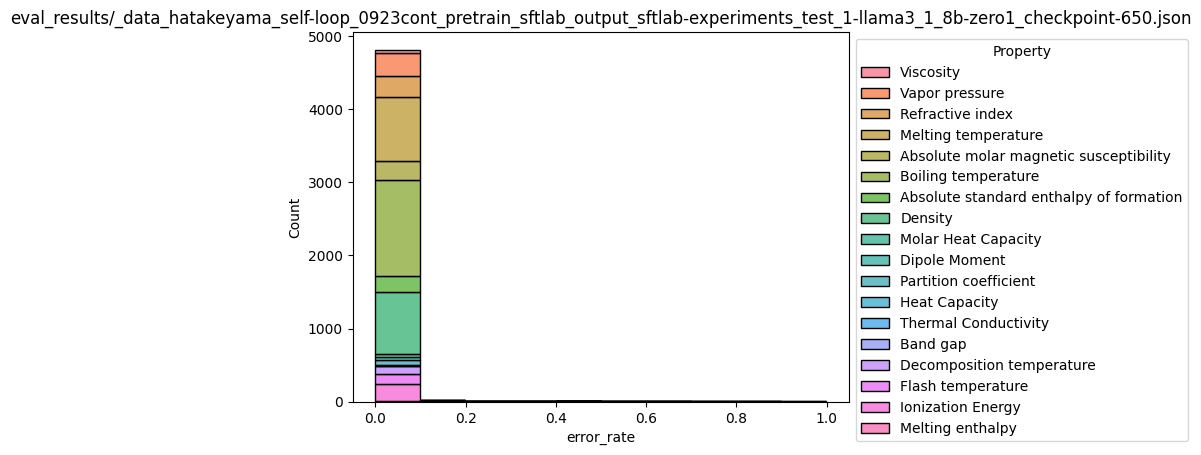

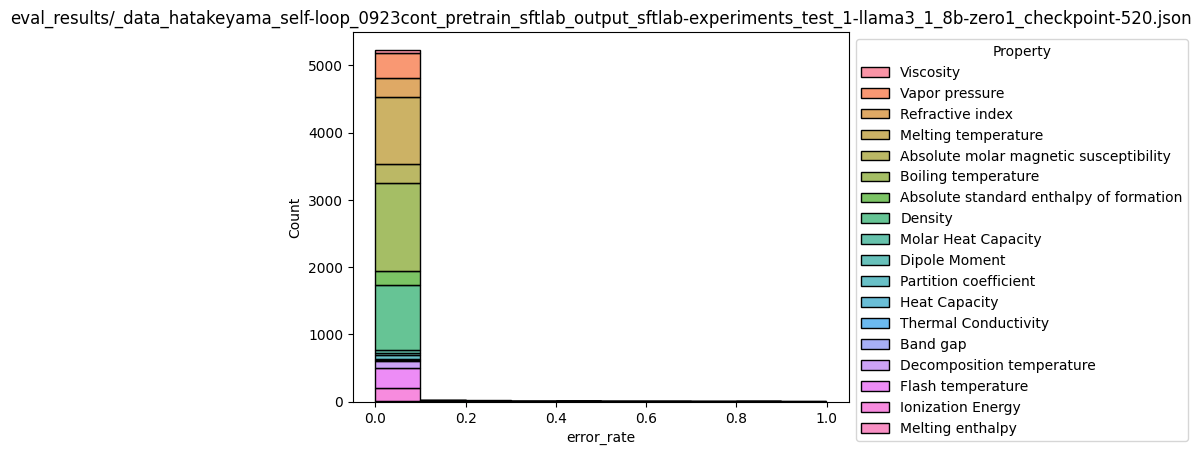

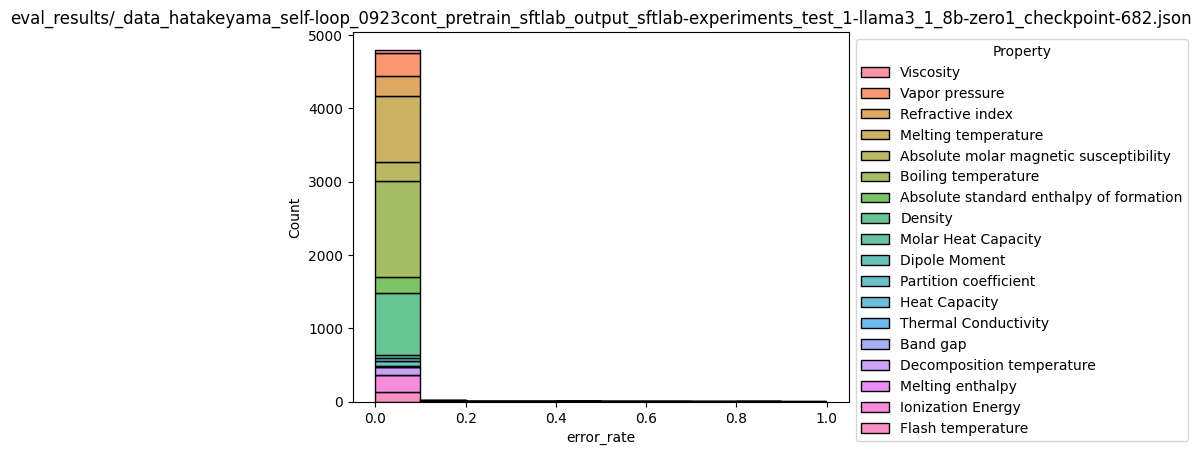

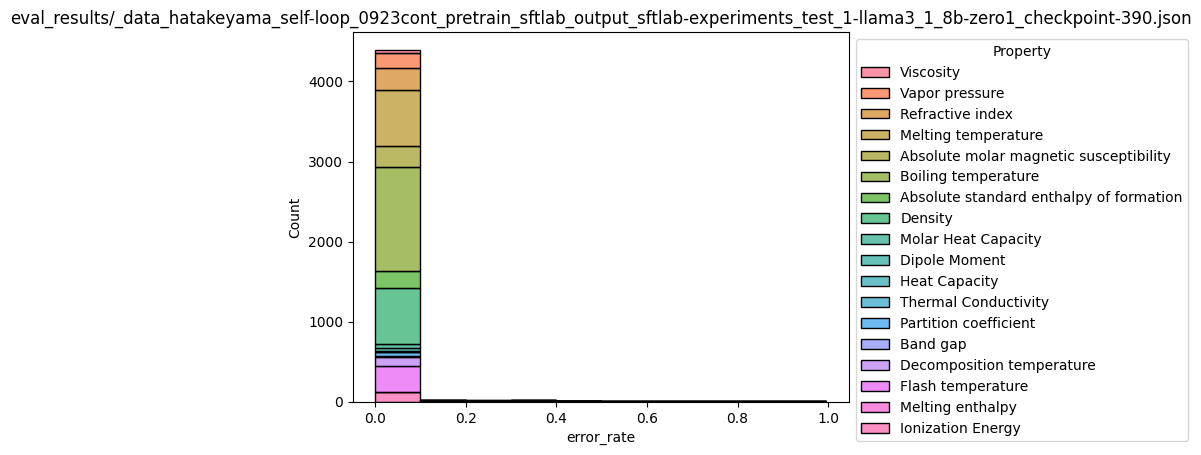

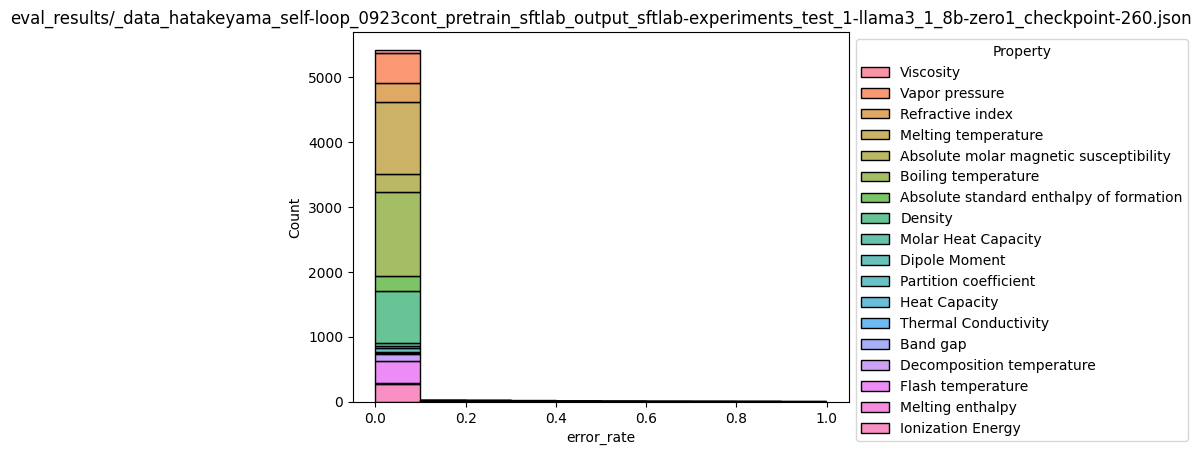

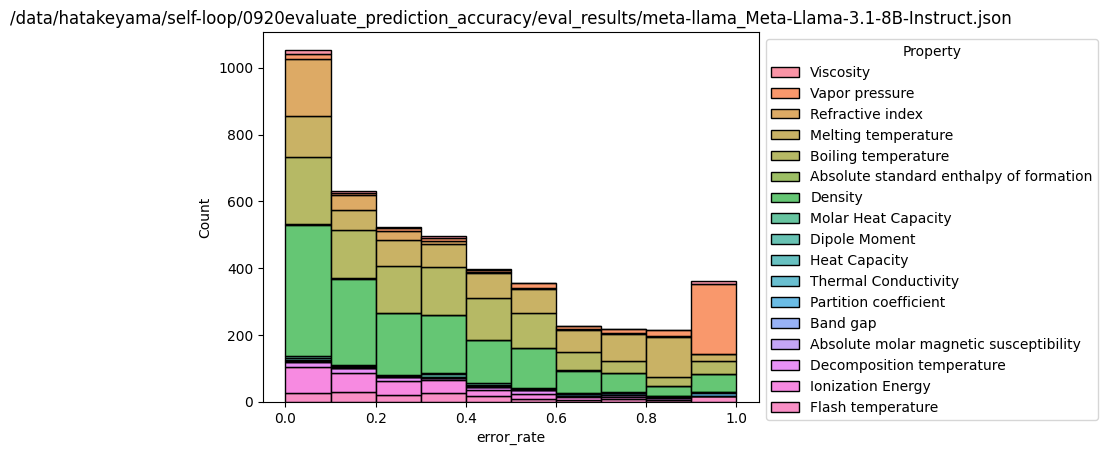

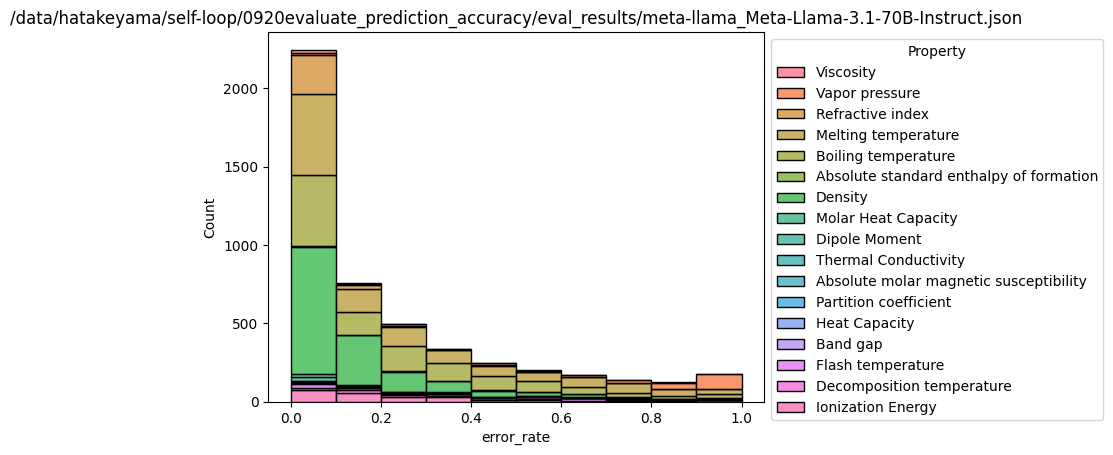

In [67]:
import glob
json_list=glob.glob("eval_results/*.json")

json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

for target_json in json_list:
    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)
        df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json)
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [33]:
predicted_text_list[16]

'The refractive index of the compound with the given SMILES O=C=O is 1.00045. This value is dimensionless, as indicated by the unit [-]. The refractive index is a measure of how much a light beam bends as it passes from one medium to another. In this case, the refractive index of 1.00045 suggests that the compound has a very slight effect on the bending of light. This is consistent with the properties of carbon dioxide, which is a colorless gas with a relatively low density. \n\nThe refractive index is an important property in various fields, including optics and chemistry. It can be used to identify substances, determine their purity, and study their optical properties. In the case of carbon dioxide, its refractive index is close to that of air, which is approximately 1.0003. This is not surprising, given that carbon dioxide is a gas at room temperature and pressure. \n\nOverall, the refractive index of 1.00045 for the compound with SMILES O=C=O is a useful piece of information for un